In [1]:
# Chargement des packages
#pip install wordcloud
#!pip install tweepy
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd 
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Description des données



La table contient des données textuelles associées à des sentiments exprimés sur les réseaux sociaux. Elle est sera utilisée  pour entraîner et évaluer un modèle de classification de sentiment associé aux tweet.


La table comprend les colonnes suivantes :

1. **target**: Cette colonne représente la polarité du sentiment exprimé dans le texte. Elle peut prendre deux valeurs :
   - Valeur 0 : correspond à un sentiment négatif.
   - Valeur 4 : correspond à un sentiment positif.

2. **ids**: Identifiant unique associé à chaque enregistrement.

3. **date**: La date et l'heure de la publication du texte.

4. **flag**: Un marqueur indiquant la provenance des données. Il peut prendre les valeurs suivantes :
   - "NO_QUERY" : indique que les données ne proviennent pas d'une requête spécifique.
   - Autres valeurs : peuvent indiquer la requête ou l'origine des données.

5. **user**: Le nom d'utilisateur de l'auteur du texte.

6. **text**: Le texte du tweet ou du message exprimant le sentiment.


Cliquez [ici](https://www.kaggle.com/datasets/kazanova/sentiment140) pour accéder à la base de données.


In [2]:
# Importation de la base de données

columns = ['target','ids','date','flag','user','text']

df=pd.read_csv("twitter.csv", encoding='ISO-8859-1',names=columns)
df

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [3]:
# Informations sur la base de données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [4]:
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [5]:
df = df[['target','text']]
df

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [6]:
df.target.unique()

array([0, 4])

In [7]:
# Remplacer le 0 par le 1

df.loc[df['target'] == 4, 'target'] = 1
df.target.unique()

array([0, 1])

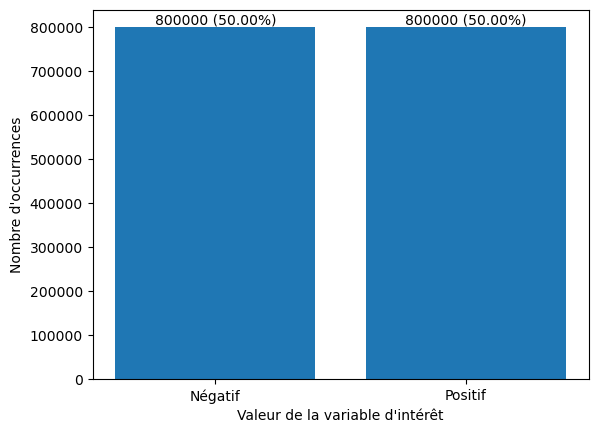

In [8]:

target_counts = df['target'].value_counts()

# Calculer la proportion pour chaque valeur de la variable d'intérêt (target)
target_proportions = df['target'].value_counts(normalize=True)

# Créer un graphique à barres pour visualiser la distribution
plt.bar(target_counts.index, target_counts.values)

# Ajouter les étiquettes des barres (nombre d'occurrences et proportion)
for i, count in enumerate(target_counts):
    proportion = target_proportions[i]
    plt.text(i, count, f"{count} ({proportion:.2%})", ha='center', va='bottom')

# Étiqueter l'axe des x et y
plt.xlabel('Valeur de la variable d\'intérêt')
plt.ylabel('Nombre d\'occurrences')

# Ajouter une légende aux barres
plt.xticks(target_counts.index, ['Négatif', 'Positif'])

# Afficher le graphique
plt.show()

In [9]:
# Sélectionner aléatoirement 10 000 tweets positifs
tweets_positifs = df[df['target'] == 1].sample(n=10000, random_state=42)

# Sélectionner aléatoirement 10 000 tweets négatifs
tweets_negatifs = df[df['target'] == 0].sample(n=10000, random_state=42)

# Concaténer les tweets positifs et négatifs sélectionnés
df_select = pd.concat([tweets_positifs, tweets_negatifs])

# Réinitialiser les index
df_select = df_select.reset_index(drop=True)
df_select


,target,text
0,1,Is lookin 4ward to a long weekend really dont...
1,1,#myweakness Is music and i live to meet the p...
2,1,figured out the Internet on my new iPod
3,1,@hillsongunited can't wait to worship with you...
4,1,@sillybeggar Congrats James !! I'm sure the bo...
...,...,...
19995,0,really hates that they are totally messing up ...
19996,0,@BrownSuga3000 THANX FOR TELLING ME!!
19997,0,really sad that graduation is coming so fast.....
19998,0,Raining cats n dogs.


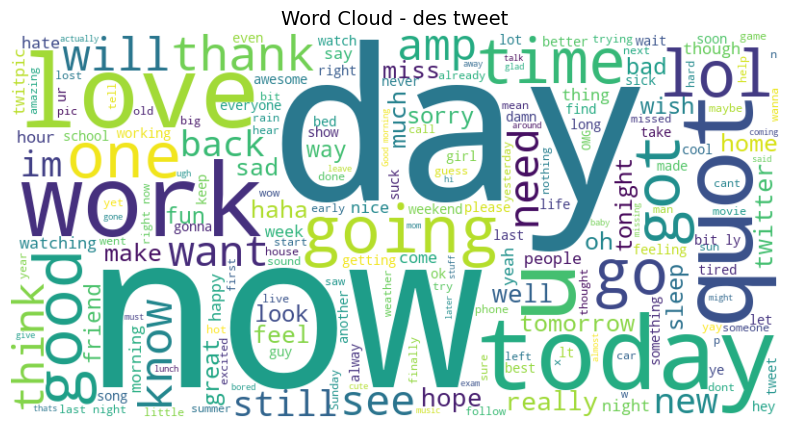

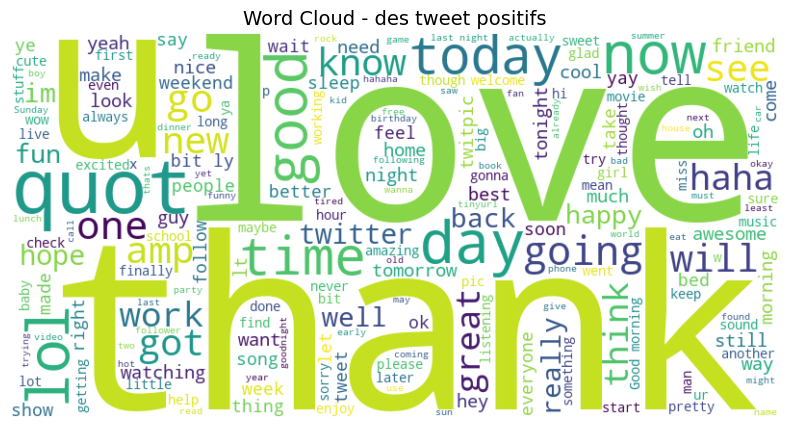

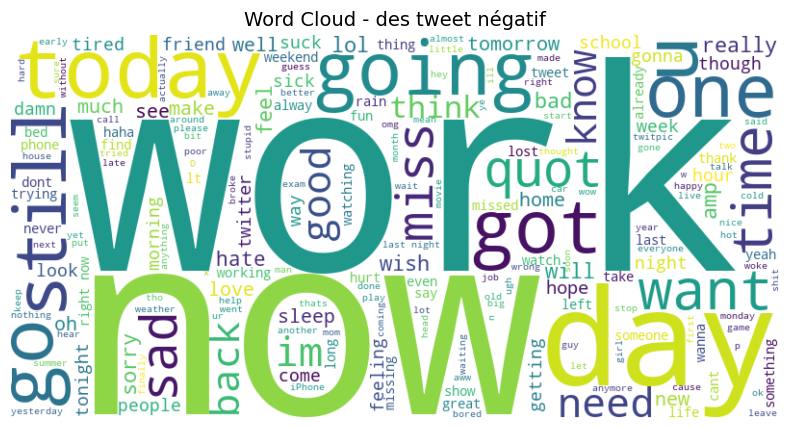

In [10]:

# Fonction pour générer le word cloud
def generer_wordcloud(tweets, titre):
    tout_texte = ' '.join(tweets)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(tout_texte)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(titre, fontsize=14)
    plt.axis('off')
    plt.show()

# Générer le word cloud pour chaque type de sentiment
generer_wordcloud(df_select['text'], 'Word Cloud - des tweet')
generer_wordcloud(tweets_positifs['text'], 'Word Cloud - des tweet positifs')
generer_wordcloud(tweets_negatifs['text'], 'Word Cloud - des tweet négatif')

# Prétraitement des tweets

**Tokenisation**
La tokenisation consiste à diviser un texte en unités linguistiques plus petites appelées "tokens". Un token peut être un mot individuel, une ponctuation ou même une partie d'un mot, selon la façon dont le texte est analysé. La tokenisation est souvent réalisée en utilisant des techniques telles que la séparation par des espaces, la reconnaissance de motifs (regex) ou l'utilisation de modèles de langage.

Par exemple, pour la phrase "Le chat est sur le tapis.", la tokenisation peut produire les tokens suivants : ["Le", "chat", "est", "sur", "le", "tapis", "."]. Chaque mot et signe de ponctuation est extrait comme un token distinct.

In [11]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')

nltk.download('stopwords')
nltk.download('punkt')


def clean_text(text):
    # Suppression des caractères spéciaux et de la ponctuation
    text = re.sub(r"[^\w\s]", "", text)
    
    # Conversion en minuscules
    text = text.lower()
    
    # Tokenisation du texte
    tokens = word_tokenize(text)
    
    # Suppression des mots vides
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Joindre les tokens en une seule chaîne
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text


# Appliquer le nettoyage du texte sur la colonne 'texte'
df_select['texte_nettoye'] = df_select['text'].apply(clean_text)

df_select


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/natachanjongwayepnga/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natachanjongwayepnga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/natachanjongwayepnga/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,target,text,texte_nettoye
0,1,Is lookin 4ward to a long weekend really dont...,lookin 4ward long weekend really dont want go ...
1,1,#myweakness Is music and i live to meet the p...,myweakness music live meet people make
2,1,figured out the Internet on my new iPod,figured internet new ipod
3,1,@hillsongunited can't wait to worship with you...,hillsongunited cant wait worship guys tonight ...
4,1,@sillybeggar Congrats James !! I'm sure the bo...,sillybeggar congrats james im sure book going ...
...,...,...,...
19995,0,really hates that they are totally messing up ...,really hates totally messing new moon favorite...
19996,0,@BrownSuga3000 THANX FOR TELLING ME!!,brownsuga3000 thanx telling
19997,0,really sad that graduation is coming so fast.....,really sad graduation coming fastand im losing...
19998,0,Raining cats n dogs.,raining cats n dogs


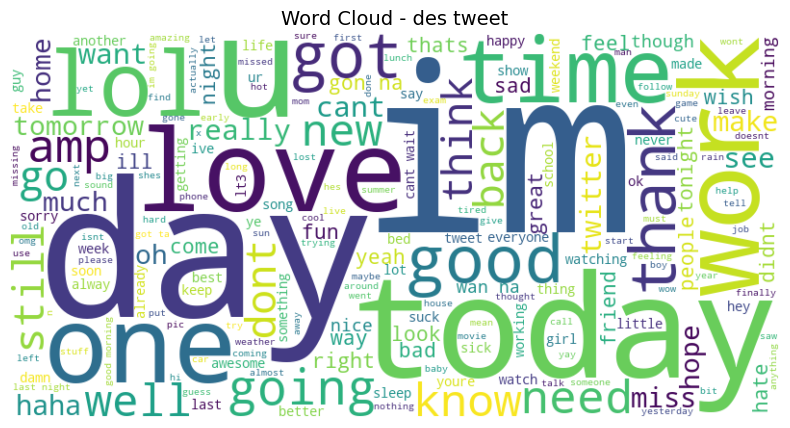

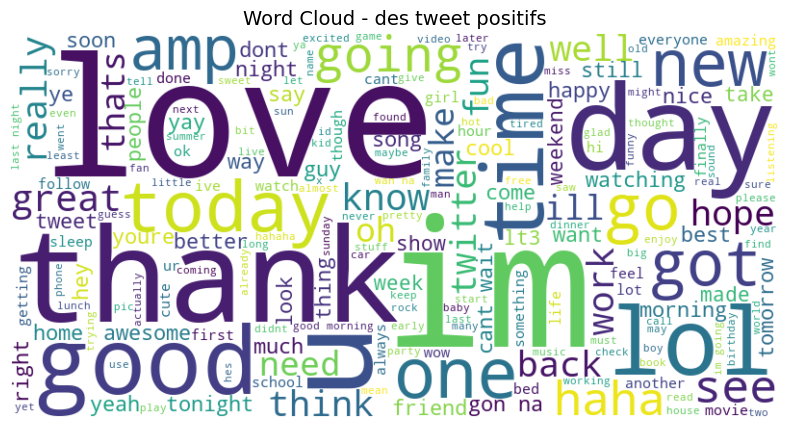

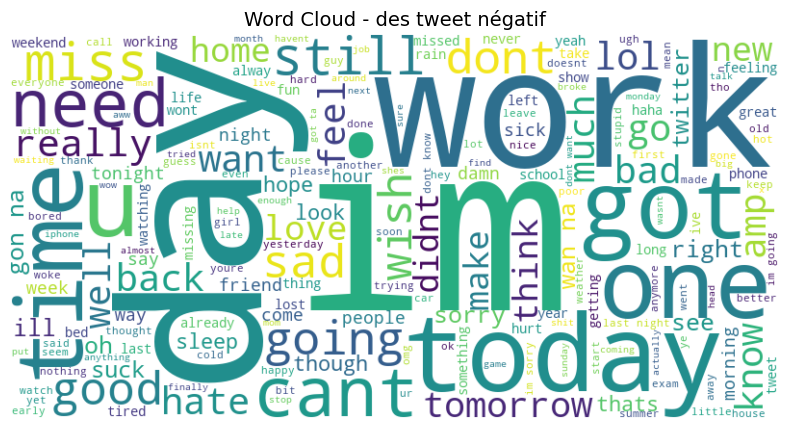

In [12]:
# Générer le word cloud pour chaque type de sentiment
generer_wordcloud(df_select['texte_nettoye'], 'Word Cloud - des tweet')
# Filtrer les tweets positifs
tweets_positifs = df_select[df_select['target'] == 1]['texte_nettoye']
generer_wordcloud(tweets_positifs, 'Word Cloud - des tweet positifs')
# Filtrer les tweets positifs
tweets_negatifs = df_select[df_select['target'] == 0]['texte_nettoye']
generer_wordcloud(tweets_negatifs, 'Word Cloud - des tweet négatif')

# Convertir le texte en numérique

##### TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF est une technique utilisée en traitement automatique du langage naturel (NLP) pour évaluer l'importance d'un terme dans un document par rapport à une collection de documents. Elle combine la fréquence du terme (TF) et l'inverse de la fréquence dans les documents (IDF).

TF mesure le nombre de fois qu'un terme apparaît dans un document, tandis que IDF évalue l'importance d'un terme dans la collection globale de documents en réduisant le poids des termes fréquents.

**En utilisant TF-IDF, on peut attribuer une valeur numérique à chaque terme, reflétant à la fois sa fréquence dans le document et son importance relative dans la collection de documents**.



Supposons que nous ayons trois documents :

Document 1 : "Le chat est mignon."

Document 2 : "Le chien est fidèle."

Document 3 : "Le chien et le chat jouent ensemble."

Calculons maintenant le score TF-IDF pour les termes "chat" et "chien" dans chaque document :

**Fréquence des termes (TF)**

TF("chat", Document 1) = 1

TF("chien", Document 1) = 0

TF("chat", Document 2) = 0

TF("chien", Document 2) = 1

TF("chat", Document 3) = 1

TF("chien", Document 3) = 1


**Fréquence inverse dans les documents (IDF)**

IDF("chat") = log(3/2) = log(1.5) ≈ 0.18

IDF("chien") = log(3/2) = log(1.5) ≈ 0.18

**TF-IDF**

TF-IDF("chat", Document 1) = 1 * 0.18 ≈ 0.18

TF-IDF("chien", Document 1) = 0 * 0.18 = 0

TF-IDF("chat", Document 2) = 0 * 0.18 = 0

TF-IDF("chien", Document 2) = 1 * 0.18 ≈ 0.18

TF-IDF("chat", Document 3) = 1 * 0.18 ≈ 0.18

TF-IDF("chien", Document 3) = 1 * 0.18 ≈ 0.18


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Créer une instance du vectoriseur TfidfVectorizer
vectorizer = TfidfVectorizer()

# Appliquer le vectoriseur sur la colonne 'texte_nettoye'
features = vectorizer.fit_transform(df_select['texte_nettoye'])

# Convertir les caractéristiques en une représentation de matrice creuse
features = features.toarray()

# Afficher les dimensions de la matrice de caractéristiques
print("Dimensions de la matrice de caractéristiques :", features.shape)

Dimensions de la matrice de caractéristiques : (20000, 33317)


In [14]:
features

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Modélisation

In [15]:
from sklearn.model_selection import train_test_split

# Diviser les données en ensembles d'entraînement et de test de façon stratifiée
X_train, X_test, y_train, y_test = train_test_split(features, df_select['target'], test_size=0.2, stratify=df_select['target'], random_state=42)


In [16]:
# Construire le modèle de régression logistique
model = LogisticRegression()
model.fit(X_train, y_train)

# Prédire les probabilités pour les ensembles d'entraînement et de test
y_train_pred = model.predict_proba(X_train)[:, 1]
y_test_pred = model.predict_proba(X_test)[:, 1]


In [17]:
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

# Calculer les valeurs de la courbe ROC
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

# Calculer l'AUC pour les ensembles d'entraînement et de test
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)


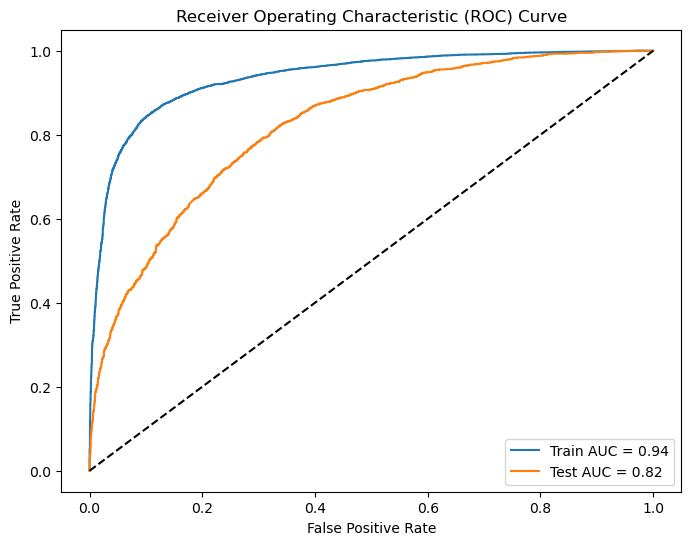

In [18]:
# Tracer la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Train AUC = {:.2f}'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test AUC = {:.2f}'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [19]:

# Calculer les performances sur les ensembles d'entraînement et de test
train_accuracy = accuracy_score(y_train, model.predict(X_train))
train_precision = precision_score(y_train, model.predict(X_train))
train_recall = recall_score(y_train, model.predict(X_train))
train_f1 = f1_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, model.predict(X_test))
test_precision = precision_score(y_test, model.predict(X_test))
test_recall = recall_score(y_test, model.predict(X_test))
test_f1 = f1_score(y_test, model.predict(X_test))

# Créer un tableau des performances
performance_table = pd.DataFrame({
    'Performance': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train': [train_accuracy, train_precision, train_recall, train_f1],
    'Test': [test_accuracy, test_precision, test_recall, test_f1]
})

print(performance_table)


  Performance     Train      Test
0    Accuracy  0.868563  0.741500
1   Precision  0.862535  0.728477
2      Recall  0.876875  0.770000
3    F1 Score  0.869646  0.748663
